In [16]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

from prettytable import PrettyTable

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from scipy import *
from scipy.sparse import *
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
path = 'Reviews.csv'
df = pd.read_csv(path)
data = df

In [3]:
#Removing Neural reviews
data_s = data[data['Score']!=3]

#Updating Score to 0 or 1
def partition(x):
    if x<3:
        return 0
    return 1

score_upd = data_s['Score']
temp = score_upd.map(partition)
data_s['Score'] = temp

In [4]:
final_data = data_s.drop_duplicates(subset=('UserId','ProfileName','Time','Text'))
final = final_data[final_data['HelpfulnessNumerator']<=final_data['HelpfulnessDenominator']]

In [5]:
final = final.sort_values(['Time'], axis=0)   #TIme based sorting
final = final.head(100000)
final_X = final['Text']
final_y = final['Score']

In [6]:
import re
temp_1 =[]
snow = nltk.stem.SnowballStemmer('english')
i = 0
N = len(final_X)
for sentence in final_X:
    sentence = sentence.lower()
    cleanr = re.compile('<.*?>')
    sentence = re.sub(cleanr, ' ', sentence)        #Removing HTML tags
    sentence = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]',r' ',sentence)        #Removing Punctuations
    
    words = [snow.stem(word) for word in sentence.split() if word not in stopwords.words('english')]        #Splitting the words
    temp_1.append(words)                                                                            # and doing stemming
    print("{0:.2f} %".format((i/N)*100),end ='\r')
    i = i+1
    
final_X = temp_1 

In [7]:
sent = []
for row in final_X:
    seq = ''
    for word in row:
        seq = seq + ' ' + word
    sent.append(seq)

final_X = sent

In [10]:
#Splitting data into train and test
#Splitting data into train and test
X_train = final_X[:70000]
X_test = final_X[70000:]
y_train = final_y[:70000]
y_test = final_y[70000:]

## SVC on BoW

In [84]:
# Bag of Words

count_vect = CountVectorizer(max_features = 5000)
bow_X_train = count_vect.fit_transform(X_train)
bow_X_test = count_vect.transform(X_test)

** GridSearchCV **

In [103]:
#c = [0.1,1]
alphas = [0.00001,0.0001,0.001,0.01,1]
clf = SGDClassifier(loss='hinge')
param_grid = {'alpha':alphas}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 3,n_jobs = 3)
grid.fit(bow_X_train, y_train)
print("best alpha = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_

best alpha =  {'alpha': 0.001}
Accuracy on train data =  92.09714285714286


In [104]:
#optimal_c1 = a.get('C') 
optimal_a1 = a.get('alpha')

In [105]:
#clf = SVC(C = optimal_c1,gamma = optimal_g1)

clf = SGDClassifier(loss='hinge',alpha = optimal_a1, class_weight='balanced') 

clf.fit(bow_X_train,y_train)

pred = clf.predict(bow_X_test)

acc1 = accuracy_score(y_test, pred) * 100
pre1 = precision_score(y_test, pred) * 100
rec1 = recall_score(y_test, pred) * 100
f11 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc1))
print('\nprecision=%f%%' % (pre1))
print('\nrecall=%f%%' % (rec1))
print('\nF1-Score=%f%%' % (f11))


Accuracy=85.980000%

precision=97.741978%

recall=85.740762%

F1-Score=91.348883%


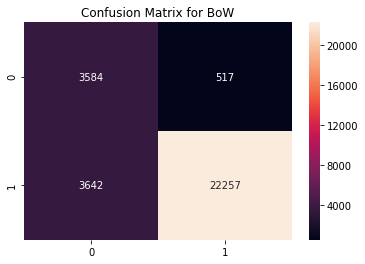

In [88]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix for BoW')
plt.show()

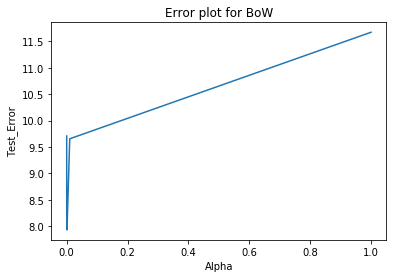

In [89]:
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
plt.plot(alphas, error)
plt.title('Error plot for BoW')
plt.xlabel('Alpha')
plt.ylabel('Test_Error')
plt.show()


In [90]:
negative_log = np.array(list(map(abs,clf.coef_))).argsort()[0][50:80]
positive_log = np.array(list(map(abs,clf.coef_))).argsort()[0][4970:5000]
negative_log = negative_log.tolist()
positive_log = positive_log.tolist()
neg={}
pos={}
for index in negative_log:
    for i in count_vect.vocabulary_:
        if count_vect.vocabulary_[i] == index:
            neg[i]=clf.coef_[0][index]
            
for index in positive_log:
    for i in count_vect.vocabulary_:
        if count_vect.vocabulary_[i] == index:
            pos[i]=clf.coef_[0][index]

In [91]:
print("Postive Words")
pos

Postive Words


{'addict': 0.7975998498546655,
 'amaz': 0.8901590417819771,
 'aw': -0.7267617953574026,
 'awesom': 0.6875359300312283,
 'best': 1.0048449853836183,
 'bland': -1.0108342259556826,
 'delici': 0.9476217192499862,
 'disappoint': -1.1518079297955284,
 'disgust': -0.6675876236393642,
 'excel': 0.9986559055984444,
 'glad': 0.6878346995477114,
 'great': 0.8863482464923704,
 'happi': 0.6519427854485008,
 'horribl': -0.7980687794931073,
 'lack': -0.6962497111609308,
 'love': 0.735131299031132,
 'nice': 0.6642398221699388,
 'perfect': 1.0631406560067962,
 'return': -0.6888655533098674,
 'smooth': 0.6788122558711742,
 'stale': -0.7805284366877288,
 'tasteless': -0.760168580233436,
 'terribl': -0.9039815837829084,
 'threw': -0.6431201809849578,
 'unfortun': -0.8426982179948648,
 'unpleas': -0.693671587452482,
 'weak': -0.7294982075514056,
 'wors': -0.673276116088934,
 'worst': -1.2054321114888722,
 'yummi': 0.7771430417029679}

In [92]:
print("Negative words")
neg

Negative words


{'6oz': 0.0018757185538068764,
 'africa': 0.0014364680063958845,
 'backpack': -0.0017965743110306322,
 'boat': -0.0013573237636194647,
 'celeri': 0.001695665401489807,
 'chewabl': 0.0014364680063968785,
 'cinnamon': 0.0013276446725782726,
 'comparison': -0.0014404252185345773,
 'el': 0.0017352375228791397,
 'enfamil': 0.0012564148540801122,
 'fatten': 0.0012168427326913862,
 'first': 0.0013019227936746309,
 'helper': 0.0014364680063963969,
 'initi': -0.0012207999448299442,
 'kashi': -0.0015591415827009869,
 'lifetim': 0.0016560932801015782,
 'lookout': 0.0011772706113026925,
 'marmalad': 0.001216842732691419,
 'nine': 0.0012168427326907504,
 'offici': 0.0018757185538067053,
 'reccommend': -0.0017965743110306604,
 'rosemari': 0.0016956654014895678,
 'safe': -0.001361280975757723,
 'skippi': -0.0017965743110304046,
 'smaller': 0.001727323098600102,
 'sniff': -0.0015373769159360564,
 'spill': -0.0011990352780664882,
 'tri': 0.0016996226136319552,
 'tuscan': 0.0016560932801015643,
 'whole'

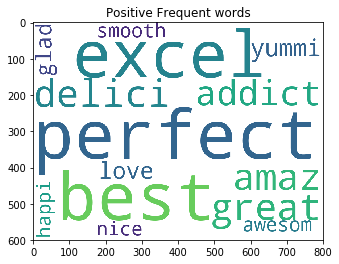

In [93]:
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 600,
background_color ='white').generate_from_frequencies(pos)
plt.imshow(wordcloud)
plt.title("Positive Frequent words")
plt.show()

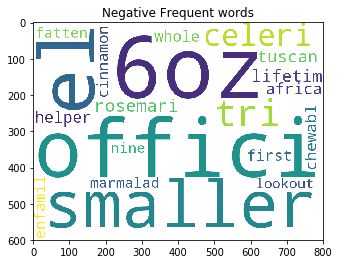

In [94]:
wordcloud = WordCloud(width = 800, height = 600,
background_color ='white').generate_from_frequencies(neg)
plt.imshow(wordcloud)
plt.title("Negative Frequent words")
plt.show()

** SVC on TF-IDF**

In [95]:
tf_idf = TfidfVectorizer(max_features=5000)
tf_X_train = tf_idf.fit_transform(X_train)
tf_X_test = tf_idf.transform(X_test)

**GridSearchCV**

In [96]:
#c = [0.1,1]
alphas = [0.00001,0.0001,0.001,0.01,1]
clf = SGDClassifier(loss='hinge')
param_grid = {'alpha':alphas}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 3,n_jobs = 3)
grid.fit(tf_X_train, y_train)
print("best alpha = ", grid.best_params_)
print("Acurracy on Train data = ",grid.best_score_*100)
a = grid.best_params_

best alpha =  {'alpha': 1e-05}
Acurracy on Train data =  92.50428571428571


In [97]:
optimal_a2 = a.get('alpha') 

In [98]:
clf = SGDClassifier(loss = 'hinge',alpha = optimal_a2,class_weight='balanced')

clf.fit(tf_X_train,y_train)

pred = clf.predict(tf_X_test)

acc2 = accuracy_score(y_test, pred) * 100
pre2 = precision_score(y_test, pred) * 100
rec2 = recall_score(y_test, pred) * 100
f12 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc2))
print('\nprecision=%f%%' % (pre2))
print('\nrecall=%f%%' % (rec2))
print('\nF1-Score=%f%%' % (f12))



Accuracy=87.080000%

precision=97.424523%

recall=87.343141%

F1-Score=92.108799%


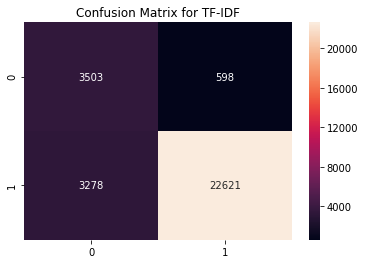

In [99]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix for TF-IDF')
plt.show()

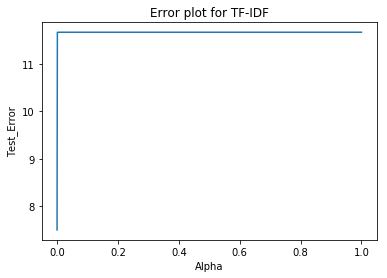

In [100]:
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
plt.plot(alphas, error)
plt.title('Error plot for TF-IDF')
plt.xlabel('Alpha')
plt.ylabel('Test_Error')
plt.show()

In [106]:
negative_log = np.array(list(map(abs,clf.coef_))).argsort()[0][50:80]
positive_log = np.array(list(map(abs,clf.coef_))).argsort()[0][4970:5000]
negative_log = negative_log.tolist()
positive_log = positive_log.tolist()
neg={}
pos={}
for index in negative_log:
    for i in tf_idf.vocabulary_:
        if tf_idf.vocabulary_[i] == index:
            neg[i]=clf.coef_[0][index]
            
for index in positive_log:
    for i in tf_idf.vocabulary_:
        if tf_idf.vocabulary_[i] == index:
            pos[i]=clf.coef_[0][index]

In [107]:
print("Postive Words")
pos

Postive Words


{'addict': 0.7924910889834318,
 'amaz': 0.8370334688181398,
 'aw': -0.7920815175270524,
 'awesom': 0.6819483464911947,
 'best': 0.8298610218165503,
 'bland': -0.9480095260395639,
 'delici': 0.9646654319319413,
 'disappoint': -1.1130114219864065,
 'disgust': -0.6560523502546669,
 'excel': 0.9750273919174705,
 'fantast': 0.6585790302053156,
 'glad': 0.6650233501734071,
 'great': 0.8962669987183449,
 'happi': 0.640666709458894,
 'horribl': -0.791822320131959,
 'lack': -0.6964693364346332,
 'love': 0.6879356084573333,
 'nice': 0.673600607484343,
 'perfect': 0.9943682662460135,
 'pleasant': 0.6437493777150403,
 'smooth': 0.6649620133852566,
 'stale': -0.7818857604513493,
 'tasteless': -0.7045479850160651,
 'terribl': -0.9314624434810373,
 'unfortun': -0.8438359164847768,
 'unpleas': -0.6359556484076017,
 'weak': -0.644301408808396,
 'worst': -1.2015006212289432,
 'yuck': -0.6492261593151785,
 'yummi': 0.7152759871244495}

In [108]:
print("Negative Words")
neg

Negative Words


{'bon': -0.0015769490373250374,
 'britain': -0.0013573237636196602,
 'caesar': -0.0015769490373256899,
 'cannist': -0.0020161995847350366,
 'caviar': -0.0017965743110308918,
 'chocol': -0.0018203175838614385,
 'chorizo': -0.0013573237636193148,
 'dal': 0.0018757185538070844,
 'dice': 0.001515612249173158,
 'distract': 0.001915290675195441,
 'doctor': 0.0017134728561137014,
 'encount': 0.0019548627965841506,
 'etc': -0.0013296232786499764,
 'garlic': 0.001371174006105631,
 'hadnt': -0.0016778579468645109,
 'harmoni': 0.0018757185538070004,
 'heap': 0.0016956654014901131,
 'michigan': 0.0016560932801017207,
 'reader': -0.001357323763620186,
 'recom': -0.0013573237636195104,
 'replenish': 0.001396895885007924,
 'shave': 0.0014364680063963275,
 'shi': 0.0018757185538070844,
 'shove': 0.001656093280101326,
 'smoother': 0.0015156122491736764,
 'thirti': 0.001436468006395775,
 'toward': 0.0013355590968570608,
 'univers': -0.0013177516422317064,
 'upscal': 0.0018757185538066643,
 'worthwhil': 

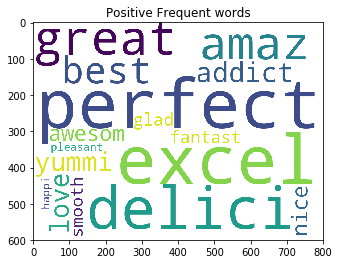

In [109]:
wordcloud = WordCloud(width = 800, height = 600,
background_color ='white').generate_from_frequencies(pos)
plt.imshow(wordcloud)
plt.title("Positive Frequent words")
plt.show()

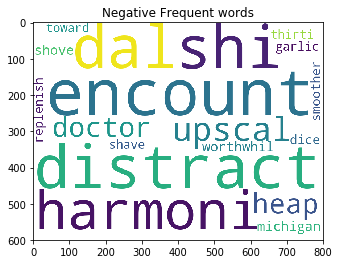

In [110]:
wordcloud = WordCloud(width = 800, height = 600,
background_color ='white').generate_from_frequencies(neg)
plt.imshow(wordcloud)
plt.title("Negative Frequent words")
plt.show()

** SVC on AVG Word2Vec **

In [116]:
w2v_data = X_train

splitted = []
for row in w2v_data: 
    splitted.append([word for word in row.split()])     #splitting words
    
train_w2v = Word2Vec(splitted,min_count=5,size=150, workers=4)

avg_X_train = []
for row in splitted:
    vec = np.zeros(150)
    count = 0
    for word in row:
        try:
            vec += train_w2v[word]
            count += 1
        except:
            pass
    avg_X_train.append(vec/count)
    
#================================================================
w2v_data = X_test

splitted = []
for row in w2v_data: 
    splitted.append([word for word in row.split()])     #splitting words
    
train_w2v = Word2Vec(splitted,min_count=5,size=150, workers=4)

avg_X_test = []
for row in splitted:
    vec = np.zeros(150)
    count = 0
    for word in row:
        try:
            vec += train_w2v[word]
            count += 1
        except:
            pass
    if count==0:
        avg_X_test.append(vec)
    else:
        avg_X_test.append(vec/count)

In [117]:
#c = [0.1,1]
alphas = [0.00001,0.0001,0.001,0.01,1]
clf = SGDClassifier(loss = 'hinge')
param_grid = {'alpha':alphas}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 3,n_jobs = 3)
grid.fit(avg_X_train, y_train)
print("best alpha = ", grid.best_params_)
print("Acurracy on Train data = ",grid.best_score_*100)
a = grid.best_params_

best alpha =  {'alpha': 0.001}
Acurracy on Train data =  90.69571428571429


In [118]:
optimal_a3 = a.get('alpha') 

In [119]:
clf = SGDClassifier(loss='hinge',alpha = optimal_a3, class_weight ='balanced')

clf.fit(avg_X_train,y_train)

pred = clf.predict(avg_X_test)

acc3 = accuracy_score(y_test, pred) * 100
pre3 = precision_score(y_test, pred) * 100
rec3 = recall_score(y_test, pred) * 100
f13 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc3))
print('\nprecision=%f%%' % (pre3))
print('\nrecall=%f%%' % (rec3))
print('\nF1-Score=%f%%' % (f13))



Accuracy=80.036667%

precision=94.138512%

recall=81.979999%

F1-Score=87.639568%


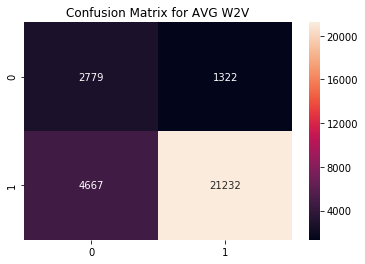

In [122]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix for AVG W2V')
plt.show()

In [121]:
del avg_X_train
del avg_X_test

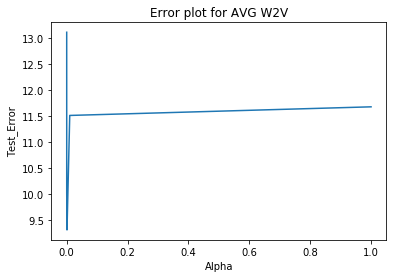

In [123]:
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
plt.plot(alphas, error)
plt.title('Error plot for AVG W2V')
plt.xlabel('Alpha')
plt.ylabel('Test_Error')
plt.show()

**SVC on TF-IDF Word2Vec**

In [131]:
tf_w_data = X_train
tf_idf = TfidfVectorizer(max_features=5000)
tf_idf_data = tf_idf.fit_transform(tf_w_data)
tf_train_data = []
tf_idf_data = tf_idf_data.toarray()
i = 0
splitted = []
for row in tf_w_data: 
    splitted.append([word for word in row.split()])
for row in splitted:
    vec = [0 for i in range(150)]
    
    temp_tfidf = []
    for val in tf_idf_data[i]:
        if val != 0:
            temp_tfidf.append(val)
    
    count = 0
    tf_idf_sum = 0
    for word in row:
        try:
            count += 1
            tf_idf_sum = tf_idf_sum + temp_tfidf[count-1]
            vec += (temp_tfidf[count-1] * train_w2v[word])
        except:
            pass
    #print(vec)
    try:
        vec = (float)(1/tf_idf_sum) * vec
    except:
        pass
    tf_train_data.append(vec)
    i = i + 1
    
    
    
#====================================================================================

tf_w_data = X_test
tf_idf_data = tf_idf.transform(tf_w_data)
tf_test_data = []
tf_idf_data = tf_idf_data.toarray()
i = 0
splitted = []
for row in tf_w_data: 
    splitted.append([word for word in row.split()])
for row in splitted:
    vec = [0 for i in range(150)]
    
    temp_tfidf = []
    for val in tf_idf_data[i]:
        if val != 0:
            temp_tfidf.append(val)
    
    count = 0
    tf_idf_sum = 0
    for word in row:
        try:
            count += 1
            tf_idf_sum = tf_idf_sum + temp_tfidf[count-1]
            vec += (temp_tfidf[count-1] * train_w2v[word])
        except:
            pass
    try:
        vec = (float)(1/tf_idf_sum) * vec
    except:
        pass
    tf_test_data.append(vec)
    i = i + 1

In [132]:
#c = [0.1,1]
alphas = [0.00001,0.0001,0.001,0.01,1]
clf = SGDClassifier(loss='hinge')
param_grid = {'alpha':alphas}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 3,n_jobs = 3)
grid.fit(tf_train_data, y_train)
print("best alpha = ", grid.best_params_)
print("Accuracy on Train data = ", grid.best_score_ *100)
a = grid.best_params_

best alpha =  {'alpha': 1e-05}
Accuracy on Train data =  88.66285714285715


In [133]:
optimal_a4 = a.get('alpha') 

In [134]:
clf = SGDClassifier(loss='hinge',alpha = optimal_a4,class_weight = 'balanced')

clf.fit(tf_train_data,y_train)

pred = clf.predict(tf_test_data)

acc4 = accuracy_score(y_test, pred) * 100
pre4 = precision_score(y_test, pred) * 100
rec4 = recall_score(y_test, pred) * 100
f14 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc4))
print('\nprecision=%f%%' % (pre4))
print('\nrecall=%f%%' % (rec4))
print('\nF1-Score=%f%%' % (f14))


Accuracy=57.116667%

precision=97.142650%

recall=51.851423%

F1-Score=67.613222%


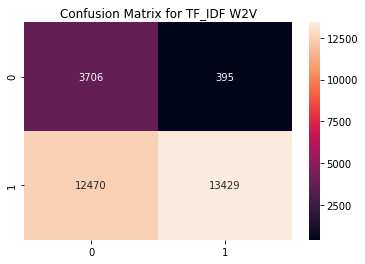

In [135]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix for TF_IDF W2V')
plt.show()

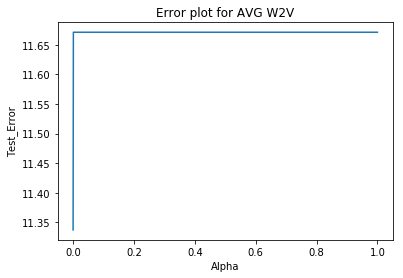

In [136]:
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
plt.plot(alphas, error)
plt.title('Error plot for AVG W2V')
plt.xlabel('Alpha')
plt.ylabel('Test_Error')
plt.show()

In [137]:
del tf_train_data
del tf_test_data

In [138]:
x = PrettyTable()

model1 = 'BoW'
model2 = 'TF-IDF'
model3 = 'Avg W2V'
model4 = 'TF-IDF W2V'
x.field_names = ["Model","Alpha","Test_Acc(%)","Test_Error(%)","Precision(%)","Recall(%)","F1-Score(%)"]

acc1 = np.around(acc1, decimals = 2)
err1 = np.around(100-acc1, decimals = 2) 
pre1 = np.around(pre1, decimals = 2)
rec1 = np.around(rec1, decimals = 2)
f11 = np.around(f11, decimals = 2)

acc2 = np.around(acc2, decimals = 2)
err2 = np.around(100-acc2, decimals = 2) 
pre2 = np.around(pre2, decimals = 2)
rec2 = np.around(rec2, decimals = 2)
f12 = np.around(f12, decimals = 2)

acc3 = np.around(acc3, decimals = 2)
err3 = np.around(100-acc3, decimals = 2) 
pre3 = np.around(pre3, decimals = 2)
rec3 = np.around(rec3, decimals = 2)
f13 = np.around(f13, decimals = 2)

acc4 = np.around(acc4, decimals = 2)
err4 = np.around(100-acc4, decimals = 2) 
pre4 = np.around(pre4, decimals = 2)
rec4 = np.around(rec4, decimals = 2)
f14 = np.around(f14, decimals = 2)

x.add_row([model1,optimal_a1,acc1,err1,pre1,rec1,f11])
x.add_row([model2,optimal_a2,acc2,err2,pre2,rec2,f12])
x.add_row([model3,optimal_a3,acc3,err3,pre3,rec3,f13])
x.add_row([model4,optimal_a4,acc4,err4,pre4,rec4,f14])

print(x)

+------------+-------+-------------+---------------+--------------+-----------+-------------+
|   Model    | Alpha | Test_Acc(%) | Test_Error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+------------+-------+-------------+---------------+--------------+-----------+-------------+
|    BoW     | 0.001 |    85.98    |     14.02     |    97.74     |   85.74   |    91.35    |
|   TF-IDF   | 1e-05 |    87.08    |     12.92     |    97.42     |   87.34   |    92.11    |
|  Avg W2V   | 0.001 |    80.04    |     19.96     |    94.14     |   81.98   |    87.64    |
| TF-IDF W2V | 1e-05 |    57.12    |     42.88     |    97.14     |   51.85   |    67.61    |
+------------+-------+-------------+---------------+--------------+-----------+-------------+


In [142]:
c = [0.1,1]
gama = [0.0001,0.001]

clf = SVC()
param_grid = {'C':c,'gamma':gama}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 3,n_jobs = 3)
grid.fit(bow_X_train, y_train)
print("best alpha = ", grid.best_params_)
print("Acurracy on Train data = ",grid.best_score_*100)
a = grid.best_params_

optimal_c = a.get('C')
optimal_g = a.get('gamma')

best alpha =  {'C': 1, 'gamma': 0.001}
Acurracy on Train data =  89.07285714285715


In [143]:
clf = SVC(C = optimal_c,gamma = optimal_g,class_weight = 'balanced')

clf.fit(bow_X_train,y_train)

pred = clf.predict(bow_X_test)

acc = accuracy_score(y_test, pred) * 100
pre = precision_score(y_test, pred) * 100
rec = recall_score(y_test, pred) * 100
f1 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc))
print('\nprecision=%f%%' % (pre))
print('\nrecall=%f%%' % (rec))
print('\nF1-Score=%f%%' % (f1))


Accuracy=85.606667%

precision=97.726569%

recall=85.312174%

F1-Score=91.098376%


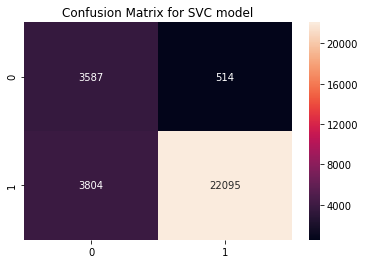

In [144]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix for SVC model')
plt.show()

In [146]:
x = PrettyTable()

model1 = 'SGD'
model2 = 'SVC'

x.field_names = ["Model","HyperParameter","Test_Acc(%)","Test_Error(%)","Precision(%)","Recall(%)","F1-Score(%)"]

acc1 = np.around(acc1, decimals = 2)
err1 = np.around(100-acc1, decimals = 2) 
pre1 = np.around(pre1, decimals = 2)
rec1 = np.around(rec1, decimals = 2)
f11 = np.around(f11, decimals = 2)

acc = np.around(acc, decimals = 2)
err = np.around(100-acc, decimals = 2) 
pre = np.around(pre, decimals = 2)
rec = np.around(rec, decimals = 2)
f1 = np.around(f1, decimals = 2)

x.add_row([model1,optimal_a1,acc1,err1,pre1,rec1,f11])
x.add_row([model2,optimal_c,acc,err,pre,rec,f1])

print(x)

+-------+----------------+-------------+---------------+--------------+-----------+-------------+
| Model | HyperParameter | Test_Acc(%) | Test_Error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+-------+----------------+-------------+---------------+--------------+-----------+-------------+
|  SGD  |     0.001      |    85.98    |     14.02     |    97.74     |   85.74   |    91.35    |
|  SVC  |       1        |    85.61    |     14.39     |    97.73     |   85.31   |     91.1    |
+-------+----------------+-------------+---------------+--------------+-----------+-------------+


** Observations and Summary **

* Considered 100k datapoints for running this model
* To reduce preprocessing times, saved already preprocessed data in pickle format and loaded that.
* Used SGDClassifier with loss function = hinge so that it acts as SVM to reduce training times.
* To find best hyperparametes used GridSearchCV and found optimal alpha = 0.001 for all 4 models.
* Used all metrics systems to have a depth look of what happening to data predictions.
* Used Pretty table to show all the data in a table format so that user can understand whats going on with every model.
* I see that BoW model gave best accuracy compared to other models.
* Compared SGD and SVC on BoW model SGD gave better accuracy compared to SVC.